# < Colab-PRO GPU Check >

In [83]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun  6 12:30:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# < IMPORT LIBRARIES >

In [95]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data Processing
import re
import nltk; nltk.download('punkt'); nltk.download('stopwords')
from sklearn.model_selection import train_test_split

# Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # to load saved Word2Vec models

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Github/Speech-And-Language-Processing

/content/drive/MyDrive/Github/Speech-And-Language-Processing


# 0. Dataset: "News Category Dataset"

## (If needed) Connect Kaggle Token

In [ ]:
from google.colab import files
files.upload() # Upload the Kaggle token file (kaggle.json)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

## 0.1 Download Data
* from Kaggle : https://www.kaggle.com/datasets/rmisra/news-category-dataset

In [ ]:
!kaggle datasets download -d rmisra/news-category-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
cd /content/drive/MyDrive/Github/Speech-And-Language-Processing/Implementations

/content/drive/MyDrive/Github/Speech-And-Language-Processing/Implementations


In [ ]:
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 1. Data Analysis

Take a look at the raw data

In [ ]:
cd /content/drive/MyDrive/Github/Speech-And-Language-Processing/Implementations

/content/drive/MyDrive/Github/Speech-And-Language-Processing/Implementations


In [ ]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Remove unnecessary columns

In [ ]:
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


Combine the '*headline*' and '*short_description*'



In [ ]:
final_df = new_df.copy()
final_df['news_combined'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['news_combined'].apply(lambda x: len(str(x)))
final_df.head()

,category,news_combined,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [ ]:
# Data Size
print("The number of documents are: {}".format(len(final_df))); print("\n")

# Label Distribution
print(final_df.info()); print("\n")
print(final_df.describe())

The number of documents are: 209527


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   category       209527 non-null  object
 1   news_combined  209527 non-null  object
 2   len_news       209527 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.8+ MB
None


            len_news
count  209527.000000
mean      172.624025
std        78.552970
min         0.000000
25%       122.000000
50%       170.000000
75%       207.000000
max      1486.000000


### Findings

1.   The length is around 172
2.   There are some empty data -> we should remove them





In [ ]:
# Remove empty data
df = final_df[final_df['len_news'] > 0]
display(df)

,category,news_combined,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233
...,...,...,...
209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,182
209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,191
209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",220
209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,173


## 1.1 Distribution of Data

In [ ]:
categories = df['category'].unique()
print("Number of Categories: {}".format(len(categories))); print()

# Count data of category
df['category'].value_counts()

Number of Categories: 42



POLITICS          35601
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6346
FOOD & DRINK       6340
BUSINESS           5991
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2943
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2578
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

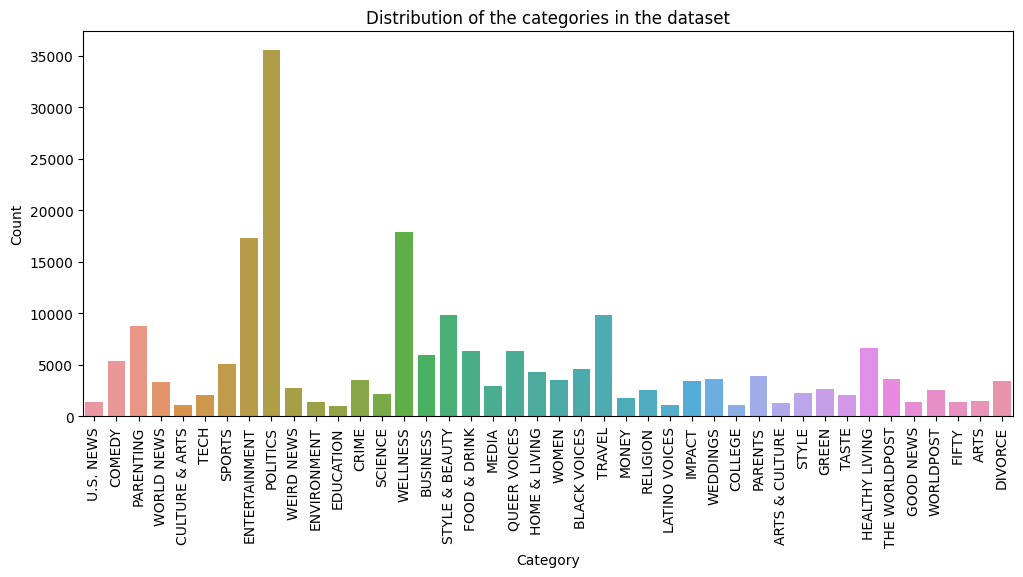

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category')

plt.title('Distribution of the categories in the dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

There are too much categories and they seem to be imbalanced. 

We can do..

1.   Downsampling
  * but downsampling to the least count will shrink the number of data too much
  * -> we could merge some relelvant data


2.   Upsampling
  * if the least-count label still seems to be so small after grouping, we can try upsampling






# 2. Data Processing

## 2.1 Merge categories

In [ ]:
def show_examples(category):
  cnt_format = "\n\"{}\": {}"; eg_format = "\a(e.g.) {}"
  news = df[df['category'] == category]
  print(cnt_format.format(category, len(news)))
  print(eg_format.format(news['news_combined'].values[0]))
  print(eg_format.format(news['news_combined'].values[1]))


# 1. Check Examples here
show_examples("WEIRD NEWS")
show_examples("IMPACT")
show_examples("FIFTY")

show_examples("PARENTS")
show_examples("PARENTING")

show_examples("MONEY")
show_examples("BUSINESS")


show_examples("THE WORLDPOST")


show_examples("ENTERTAINMENT")

show_examples("GREEN")

show_examples("MEDIA")

show_examples("HEALTHY LIVING")



"WEIRD NEWS": 2777
(e.g.) 'French Spider-Man' Celebrates 60th Birthday With A Massive Skyscraper ClimbAlain Robert, known as the "French Spider-Man," has climbed the Burj Khalifa and the Empire State Building.
(e.g.) German Customs Officials Follow Trail Of Slime And Find Bags Of Giant Snails“Never in the history of the Duesseldorf customs office has a trail of slime led us to smuggled goods,” spokesman Michael Walk told the media.

"IMPACT": 3484
(e.g.) Why You Shouldn't Recycle ReceiptsCVS and other companies are shortening excessively long receipts and removing potentially harmful chemicals. That's good for the environment and your health.
(e.g.) How One Of The World's Rarest Hummingbirds Is Helping Save The Cloud Forests Of PeruThe marvelous spatuletail hummingbird inspired a culture of conservation in the Andes Mountains.

"FIFTY": 1401
(e.g.) Love, Facebook and Infidelity
(e.g.) Boomers Were Time's "Man of the Year" Fifty Years Ago

"PARENTS": 3955
(e.g.) 40 Tweets That S

## 2.1 Re-Group Similar Categories


```
* NEWS: { U.S. NEWS, WORLD NEWS, THE WORLDPOST, WORLDPOST}
* SOCIAL: { LATINO VOICES, BLACK VOICES, QUEER VOICES, RELIGION, IMPACT, CRIME }
* CULTURE & ART: { CULTURE & ARTS, ARTS & CULTURE, ARTS }
* EDUCATION: { EDUCATION, COLLEGE }
* LIVING: { HOME & LIVING, HEALTHY LIVING }
* FOOD: { TASTE, FOOD & DRINK }
* FAMILY: { WEDDING, PARENTING, PARENTS, DIVORCE }
* ENVIRONMENT: { GREEN, ENVIRONMENT }
* ECONOMICS: { MONEY, BUSINESS }
* SCIENCE & TECH: { SCIENCE, TECH }
* STYPE & BEAUTY: { STYLE, STYLE & BEAUTY }
* ETC: { FIFTY, GOOD NEWS, WEIRD NEWS }
```

In [ ]:
news = ["U.S. NEWS", "WORLD NEWS", "THE WORLDPOST", "WORLDPOST"]
social = ["LATINO VOICES", "BLACK VOICES", "QUEER VOICES", "RELIGION", "IMPACT", "CRIME"]
culture_and_art = ["CULTURE & ARTS", "ARTS & CULTURE", "ARTS"]
education = ["EDUCATION", "COLLEGE"]
living = ["HOME & LIVING", "HEALTHY LIVING", "WELLNESS"]
food = ["TASTE", "FOOD & DRINK"]
family = ["WEDDINGS", "PARENTING", "PARENTS", "DIVORCE"]
environment = ["GREEN", "ENVIRONMENT"]
economics = ["MONEY", "BUSINESS"]
science_and_tech = ["SCIENCE", "TECH"]
style_and_beauty = ["STYLE", "STYLE & BEAUTY"]
others = {"FIFTY", "GOOD NEWS", "WEIRD NEWS"}

new_categories = {"NEWS": news, "SOCIAL": social, "CULTURE & ART": culture_and_art, "EDUCATION": education, "LIVING": living, "FOOD": food, "FAMILY": family, 
                  "ENVIRONMENT": environment, "ECONOMICS": economics, "SCIENCE & TECH": science_and_tech, "STYLE & BEAUTY": style_and_beauty, "OTHERS": others}

for category, names in new_categories.items():
  for name in names:
    df.loc[df['category'] == name, "category"] = category

Numner of Categories: 19

POLITICS          35601
LIVING            28959
SOCIAL            21682
FAMILY            19825
ENTERTAINMENT     17362
STYLE & BEAUTY    12068
NEWS              10918
TRAVEL             9900
FOOD               8436
ECONOMICS          7747
OTHERS             5576
COMEDY             5400
SPORTS             5077
SCIENCE & TECH     4310
ENVIRONMENT        4066
CULTURE & ART      3922
WOMEN              3572
MEDIA              2943
EDUCATION          2158
Name: category, dtype: int64



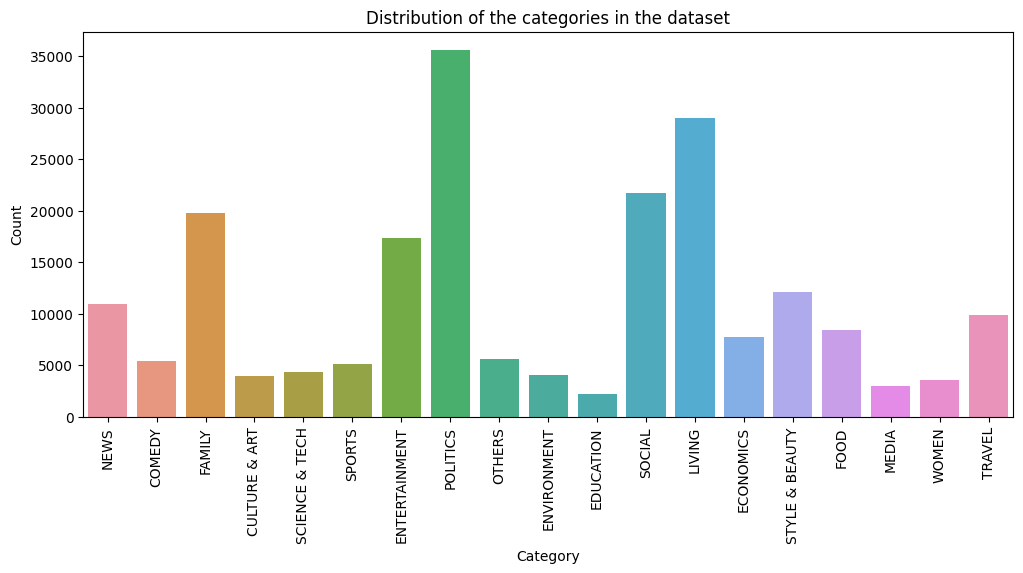

In [ ]:
categories = df['category'].unique()
print("Numner of Categories: {}".format(len(categories))); print()

# Count data of category
print(df['category'].value_counts()); print()

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category')

plt.title('Distribution of the categories in the dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

The number of categories reduced from **42** to **19**

## 2.3 Clean / Tokenize

Before going further, first tokenize and clean the data



1. Remove punctuations
2. Remove URL / Emoji 
3. Remove Contractions (e.g. "~n't" -> "~ not")
4. Separate Alpha-Numerics

5. Remove Stopwords



In [ ]:
# Preprocess the data
class Preprocess:
  """
    1. Basic Processing
      1) Remove Uneccesary parts
        - punctuations / special characters (non-alphabetic / non-digit characters)
        - URL
        - Emoji
      2) Remove Contraction
  """
  def remove_punct(text: str): # Remove punctuations and special characters
      return re.sub('[^a-zA-Z0-9]+', ' ', text)
  
  def remove_url(text: str): # Remove URLS
      url = re.compile(r'https?://\S+|www\.\S+')
      return url.sub(r'',text)
  
  def remove_emoji(text: str): # Remove EMOJIs
      emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
      return emoji_pattern.sub(r'', text)

  def remove_contraction(text: str): # Remove Contraction
      text = re.sub(r"won\'t", " will not", text)
      text = re.sub(r"won\'t've", " will not have", text)
      text = re.sub(r"can\'t", " can not", text)
      text = re.sub(r"don\'t", " do not", text)
      
      text = re.sub(r"can\'t've", " can not have", text)
      text = re.sub(r"ma\'am", " madam", text)
      text = re.sub(r"let\'s", " let us", text)
      text = re.sub(r"ain\'t", " am not", text)
      text = re.sub(r"shan\'t", " shall not", text)
      text = re.sub(r"sha\n't", " shall not", text)
      text = re.sub(r"o\'clock", " of the clock", text)
      text = re.sub(r"y\'all", " you all", text)

      text = re.sub(r"n\'t", " not", text)
      text = re.sub(r"n\'t've", " not have", text)
      text = re.sub(r"\'re", " are", text)
      text = re.sub(r"\'s", " is", text)
      text = re.sub(r"\'d", " would", text)
      text = re.sub(r"\'d've", " would have", text)
      text = re.sub(r"\'ll", " will", text)
      text = re.sub(r"\'ll've", " will have", text)
      text = re.sub(r"\'t", " not", text)
      text = re.sub(r"\'ve", " have", text)
      text = re.sub(r"\'m", " am", text)
      text = re.sub(r"\'re", " are", text)
      return text 

  """
    2. Additional Processing
      1) Separate Alpha-Numeric
      2) Tokenize
      3) Remove Stopwords
          - should be held after tokenizing
  """

  def seperate_alphanumeric(text: str): #Seperate alphanumeric characters
      words = text
      words = re.findall(r"[^\W\d_]+|\d+", words)
      return " ".join(words)

  def tokenize(text: str):
    return nltk.word_tokenize(text)

  def remove_stopwords(tokens, return_type='string'):
    stop_words = nltk.corpus.stopwords.words('english')
    clean_tokens = [word for word in tokens if word not in stop_words]
    #return clean_tokens
    if return_type == 'string':
      return " ".join(clean_tokens)
    elif return_type == 'list':
      return clean_tokens
    else:
      raise Exception("check your return_type: must be 'string'/'list'.")

# ----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------

def preprocess_text(raw_text, return_type='string'):
  # 0. Convert to Lowercase
  text = raw_text.lower();

  # 1. Basic Processing
  text = Preprocess.remove_punct(text); text = Preprocess.remove_url(text); text = Preprocess.remove_emoji(text);
  text = Preprocess.remove_contraction(text);
  # 2. Additional Processing
  text = Preprocess.seperate_alphanumeric(text);
  text = Preprocess.tokenize(text);
  text = Preprocess.remove_stopwords(text, return_type);
  return text



In [ ]:
# Remove the length column
clean_df = df.drop(columns=['len_news'])


print("Before Preprocessing\n")
display(clean_df.head()); print()
print("(e.g.) ", clean_df['news_combined'].values[0], "\n")


# Apply Preprocessing
print("\n<< Preprocessing >>\n")
clean_df_str = clean_df.copy(deep=False); clean_df_str['news_combined'] = clean_df_str['news_combined'].apply(lambda text: preprocess_text(text, return_type='string')); print("... finished 1/2")
clean_df_list = clean_df.copy(deep=False); clean_df_list['news_combined'] = clean_df_list['news_combined'].apply(lambda text: preprocess_text(text, return_type='list')); print("... finished 2/2")

print("After Preprocessing\n")
print("- text in string\n")
display(clean_df_str.head()); print()
print("(e.g.) ", clean_df_str['news_combined'].values[0], "\n")

print("- text in tokens\n")
display(clean_df_list.head()); print()
print("(e.g.) ", clean_df_list['news_combined'].values[0], "\n")

Before Preprocessing



,category,news_combined
0,NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,FAMILY,The Funniest Tweets From Parents This Week (Se...
4,NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...



(e.g.)  Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID BoostersHealth experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall. 


<< Preprocessing >>

... finished 1/2
... finished 2/2
After Preprocessing

- text in string



,category,news_combined
0,NEWS,4 million americans roll sleeves omicron targe...
1,NEWS,american airlines flyer charged banned life pu...
2,COMEDY,23 funniest tweets cats dogs week sept 17 23 d...
3,FAMILY,funniest tweets parents week sept 17 23 accide...
4,NEWS,woman called cops black bird watcher loses law...



(e.g.)  4 million americans roll sleeves omicron targeted covid boostershealth experts said early predict whether demand would match 171 million doses new boosters u ordered fall 

- text in tokens



,category,news_combined
0,NEWS,"[4, million, americans, roll, sleeves, omicron..."
1,NEWS,"[american, airlines, flyer, charged, banned, l..."
2,COMEDY,"[23, funniest, tweets, cats, dogs, week, sept,..."
3,FAMILY,"[funniest, tweets, parents, week, sept, 17, 23..."
4,NEWS,"[woman, called, cops, black, bird, watcher, lo..."



(e.g.)  ['4', 'million', 'americans', 'roll', 'sleeves', 'omicron', 'targeted', 'covid', 'boostershealth', 'experts', 'said', 'early', 'predict', 'whether', 'demand', 'would', 'match', '171', 'million', 'doses', 'new', 'boosters', 'u', 'ordered', 'fall'] 



In [ ]:
# Save Preprocessed data into CSV
os.makedirs('Preprocessed-Data', exist_ok=True)  
clean_df_str.to_csv('Preprocessed-Data/clean_df_str.csv')  
clean_df_list.to_csv('Preprocessed-Data/clean_df_list.csv')

## 2.2 Downsampling

First, try downsample the data to the least apperances of labels.

In [ ]:
# Take an equal number of samples based on the least occurring label
min_count = clean_df_str['category'].value_counts().min()
df_reduced = clean_df_str.groupby('category').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(f"Number of samples per Category: {min_count}")

# Split train and test data
dwn_train, dwn_test = train_test_split(df_reduced, test_size=0.2, random_state=42)

print(f"Train dataset shape: {dwn_train.shape}")
print(f"Test dataset shape: {dwn_test.shape}")

Number of samples per Category: 2158
Train dataset shape: (32801, 2)
Test dataset shape: (8201, 2)


## 2.3 (TODO) Upsampling

# 3. Supervised Models

## 3.1 Baseline Models


1.   Logistic Regression Classifier



### 1) TF-IDF Vectorization

In [ ]:
# Use TF-IDF to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(min_df=1)
tfidf2 = TfidfVectorizer(min_df=2) # I set min_df to 3 in order to remove unnecessary words

dwn_train_vectors1 = tfidf1.fit_transform(df_reduced['news_combined'])
dwn_train_vectors2 = tfidf2.fit_transform(df_reduced['news_combined'])

In [ ]:
print(f"Number of features \n- TF-IDF 1: {len(tfidf1.get_feature_names_out())}\n- TF-IDF 2: {len(tfidf2.get_feature_names_out())}\n")
difference = list(set(tfidf1.get_feature_names_out()) - set(tfidf2.get_feature_names_out()))

import random
print("Difference Examples")
for i in range(20):
  print(random.choices(difference, k=10))

Number of features 
- TF-IDF 1: 67657
- TF-IDF 2: 27324

Difference Examples
['algarve', 'sienna', 'streetone', 'drivingtexting', 'grantslet', 'republitronthe', 'williamsand', 'howlidays', 'resultsscientists', 'valuesone']
['mci', 'squatty', 'digwho', 'futureridley', 'withheld', 'lattesalute', 'juggle', 'carnivorousliving', 'importantsocial', 'domaroberta']
['runinspired', 'festivalblindfold', 'fixedof', 'winethere', 'gardiner', 'spinnerfamily', 'hashtagslate', 'reshma', 'spajeni', 'plaits']
['achievable', 'shinique', 'nosecreator', 'sodathe', 'editiontoday', 'yearsecret', 'unclearsept', 'usga', 'broadcasterowning', 'flightkeep']
['reynot', 'collided', 'signcall', 'growsdespite', 'wallsadd', 'underaged', 'wormnado', 'colleaguesi', 'kristan', 'everthat']
['ascribed', 'closethanksgiving', 'appearancewhile', 'brainsby', 'upyou', 'bullyit', 'bethere', 'seriestidal', 'hoursure', 'healthwomen']
['acker', 'luxuriate', 'unexpectedlyit', 'timela', 'portraitsoscar', 'shaddix', 'boatit', 'sudsed'

In [ ]:
print("PRINT RANDOM Words\n")
for i in range(10):
  print(random.choices(tfidf2.get_feature_names_out(), k=10))
print("\n\n");

print("PRINT FIRST 300 Words\n")
for i in range(30):
  print(tfidf2.get_feature_names_out()[i*10:i*10+10])

PRINT RANDOM Words

['doubles', 'financed', 'kauai', 'tropical', 'versace', 'rodents', 'cake', 'kathleen', 'anyone', 'legacy']
['focuses', 'plane', 'zhou', 'indulgence', 'bagels', 'itlondon', 'charges', 'feelin', 'personali', 'lucky']
['identified', 'myanmarthe', 'rachel', 'internetthe', 'celebrating', 'caveman', 'dictate', 'coastlines', 'unfolding', 'reducing']
['confiscated', 'grind', 'aspen', 'strewn', 'chopper', 'designated', 'establish', 'lang', 'nightshe', 'tale']
['murdochs', 'zap', 'filling', 'reliever', 'figs', 'frontrunner', 'finland', 'durable', 'dunn', 'lob']
['endorsementthe', 'shark', 'majoring', 'windows', 'scratchy', 'quack', 'philosophy', 'rallied', 'debunking', 'northeastern']
['sir', 'redefine', 'plants', 'intergenerational', 'anarchy', 'virus', 'poole', 'attitude', 'incarcerated', 'comply']
['damascus', 'taxation', 'traveli', 'reenergize', 'business', 'kidsthe', 'payoff', 'hay', 'suffering', 'stonewall']
['dreaming', 'predawn', 'instant', 'chemist', 'genesis', 'boun

There still seems to be many unnecessary features -> it takes more than 300 to reach an actual 'word'

* we can merge the numbers into a single group => "numbergroup"
* (I didn't remove them because the presence of numbers can be an important clues for classifying news)

In [ ]:
print("Is \"numbergroup\" an exsiting token? : ",("numbergroup" in tfidf2.get_feature_names_out())); print()
# --> since "numbergroup" isn't an existing token, change all the numbers to "numbergroup"

# 1. Merge numbers into a 'numbergroup' category
def merge_numbers(text: str): 
    return re.sub('[0-9]+', 'numbergroup', text)
  
df_reduced['news_combined'] = df_reduced['news_combined'].apply(lambda x: merge_numbers(str(x)))
print("After Merging Numbers"); print()
display(df_reduced.head()); print()
# 2. Use TF-IDF to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf2 = TfidfVectorizer(min_df=2) # I set min_df to 2 in order to remove unnecessary words
X_tfidf = tfidf2.fit_transform(df_reduced['news_combined'])


print("Numner of words: ",  len(tfidf2.get_feature_names_out())); print()


print("PRINT FIRST 50 Words\n")
for i in range(10):
  print(tfidf2.get_feature_names_out()[i*5:i*5+5])

Is "numbergroup" an exsiting token? :  False

After Merging Numbers



,category,news_combined
0,COMEDY,psychometer went far last week picture psychom...
1,COMEDY,anthony scaramucci tells r rated spoof intervi...
2,COMEDY,jimmy kimmel montage proves donald trump mover...
3,COMEDY,america undecided voters need answers saturday...
4,COMEDY,everyday items home say deeper levela mellon b...



Numner of words:  26983

PRINT FIRST 50 Words

['aaliyah' 'aap' 'aaron' 'aarp' 'aasif']
['aau' 'ab' 'aback' 'abandon' 'abandoned']
['abandoning' 'abandonment' 'abba' 'abbas' 'abbey']
['abbi' 'abbott' 'abbreviations' 'abby' 'abc']
['abdication' 'abdominal' 'abducted' 'abduction' 'abdul']
['abdullah' 'abe' 'abedin' 'abel' 'abercrombie']
['abhorrent' 'abid' 'abide' 'abigail' 'abilities']
['ability' 'ablaze' 'able' 'abnormal' 'abnormality']
['abnormally' 'aboard' 'abolish' 'aborigines' 'aborted']
['aborting' 'abortion' 'abortions' 'abortionsthe' 'abortionthe']


### < DOCUMENT-WORD VECTORS >

In [ ]:
print(X_tfidf.shape)

(41002, 26983)


* the size is (41002, 26933) which is (document_no, word_no)

In [ ]:
train, test = train_test_split(df_reduced, test_size=0.2, random_state=42)

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}"); print()

tfidf2 = TfidfVectorizer(min_df=2) # I set min_df to 2 in order to remove unnecessary words
X_train = tfidf2.fit_transform(train['news_combined']); y_train = train['category']
X_test = tfidf2.transform(test['news_combined']); y_test = test['category']


print(f"X_Train shape: {X_train.shape}")
print(f"X_Test shape: {X_test.shape}")

Train dataset shape: (32801, 2)
Test dataset shape: (8201, 2)

X_Train shape: (32801, 24044)
X_Test shape: (8201, 24044)


## 2) Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=1000) # use cross-entroy loss by setting multi_class='multinomial'
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

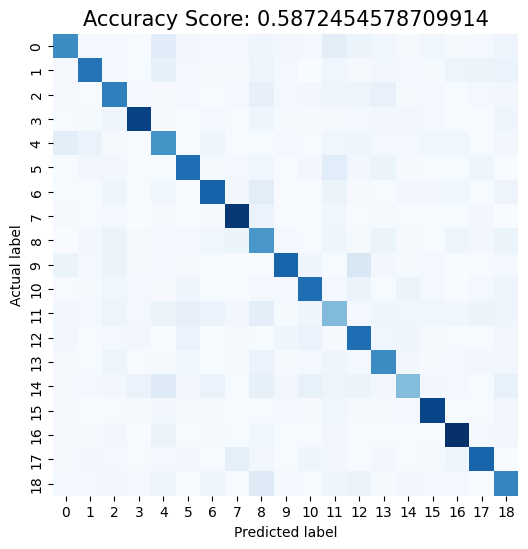




                precision    recall  f1-score   support

        COMEDY       0.62      0.48      0.54       461
 CULTURE & ART       0.65      0.57      0.61       444
     ECONOMICS       0.53      0.56      0.55       425
     EDUCATION       0.75      0.70      0.73       454
 ENTERTAINMENT       0.46      0.53      0.49       398
   ENVIRONMENT       0.62      0.62      0.62       426
        FAMILY       0.65      0.60      0.63       459
          FOOD       0.72      0.78      0.75       428
        LIVING       0.39      0.51      0.44       405
         MEDIA       0.69      0.61      0.65       451
          NEWS       0.62      0.63      0.63       414
        OTHERS       0.37      0.35      0.36       437
      POLITICS       0.54      0.61      0.57       429
SCIENCE & TECH       0.53      0.58      0.56       381
        SOCIAL       0.49      0.34      0.40       449
        SPORTS       0.69      0.76      0.73       416
STYLE & BEAUTY       0.71      0.75      0.7

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Plot Confusion Matrix
confusion_LR = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,6)); sns.heatmap(confusion_LR,  cmap='Blues', cbar=False)
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15)
plt.show(); print("\n\n")

# 2. Print Report
print(classification_report(y_test, predictions))

### Obtained a Baseline of 59% accuracy,
### -> TF-IDF Vectorization in Logistic Regression Classifier

### 3) Word2Vec Vectorization
* Here, I will use Word2Vec features for supervised learning

In [94]:
word2vec = Word2Vec(sentences=clean_df_list['news_combined'], vector_size=100, window=5, min_count=5, workers=4, sg=0)
word2vec.save("Word2Vec-NewsCategoryDataset.model")

In [97]:
pretrained_word2vec = Word2Vec.load("Word2Vec-NewsCategoryDataset.model")

In [163]:
print("Word2Vec Embeddings\n\n")

words = ['hate', 'man', 'beauty']
for word in words:
  print("\a<< " + word.upper() + " >>\n")
  model_result = pretrained_word2vec.wv.most_similar(word)
  for result in model_result:
    print(result)
  print("\n")

Word2Vec Embeddings


<< HATE >>

('blaming', 0.6515874266624451)
('crime', 0.6332139372825623)
('christians', 0.6297754645347595)
('angry', 0.6278164982795715)
('pray', 0.608464241027832)
('hateful', 0.6041449904441833)
('offended', 0.5965772867202759)
('muslims', 0.5958063006401062)
('gays', 0.5938329100608826)
('muslim', 0.5936985015869141)


<< MAN >>

('woman', 0.7876815795898438)
('cop', 0.6776565909385681)
('boy', 0.6676169633865356)
('cops', 0.631270706653595)
('person', 0.6280926465988159)
('guy', 0.6277011632919312)
('teenager', 0.5890563726425171)
('mani', 0.5869544744491577)
('neighbor', 0.560280978679657)
('dog', 0.5544309616088867)


<< BEAUTY >>

('makeup', 0.7453089356422424)
('accessories', 0.673831582069397)
('timeless', 0.663655161857605)
('beast', 0.6628159284591675)
('magazines', 0.6603932976722717)
('wardrobe', 0.6578560471534729)
('feminine', 0.6497212052345276)
('glamour', 0.6414591073989868)
('skincare', 0.6354113221168518)
('style', 0.6326304078102112)




In [167]:
# Example of a word vector
pretrained_word2vec.wv.get_vector('happy').shape

(100,)

In [212]:
def average_word2vec(tokens, model):
  result = np.zeros(model.vector_size); word_cnt = len(tokens)
  for token in tokens:
    try: result += model.wv.get_vector(token)
    except: word_cnt -= 1; continue # ignore unknown words
  if (word_cnt != 0):
    result /= word_cnt
  return result

In [213]:
sentence = clean_df_list['news_combined'][0]
print(sentence)

['4', 'million', 'americans', 'roll', 'sleeves', 'omicron', 'targeted', 'covid', 'boostershealth', 'experts', 'said', 'early', 'predict', 'whether', 'demand', 'would', 'match', '171', 'million', 'doses', 'new', 'boosters', 'u', 'ordered', 'fall']


In [214]:
average_word2vec(sentence, pretrained_word2vec)

array([-0.0775343 ,  0.50718589,  0.3236294 ,  0.42672446, -0.48910188,
       -0.06991298, -0.17888738,  0.0075199 , -0.15315764,  0.15251356,
        0.42273841, -0.52245643, -0.1883491 ,  0.37013045, -0.04307512,
        0.00939628,  0.17936253,  0.07034171,  0.45339536,  0.37999994,
        0.59962079, -0.40431569, -0.45940908, -0.16908135,  0.10331826,
        0.4584186 , -0.35709948, -0.23531903,  0.65858123, -0.14484907,
        0.08763734,  0.40323747, -0.330275  , -0.31336384, -0.24535763,
        0.46739272, -0.10554961, -1.07029253, -0.10446326,  0.10518001,
       -0.09726682, -0.02994426,  0.2710742 , -0.28904024,  0.6358836 ,
        0.11383706, -0.54420785, -0.36349074,  0.02658411,  0.0532093 ,
       -0.04399413,  0.31659548,  0.01721498,  0.06522571, -0.31486651,
       -0.3306677 ,  0.26230131, -0.18650363, -0.42823242, -0.34365255,
       -0.55116761,  0.1360202 ,  0.06323209,  0.06737966, -0.22231704,
       -0.31966185, -0.25368376, -0.08557238,  0.09851628,  0.54

In [215]:
# Take an equal number of samples based on the least occurring label
min_count = clean_df_list['category'].value_counts().min()
df_reduced = clean_df_list.groupby('category').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(f"Number of samples per Category: {min_count}")

# Split train and test data
train, test = train_test_split(df_reduced, test_size=0.2, random_state=42)

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}"); print()

# Apply Word2Vec
train['news_combined'] = train['news_combined'].apply(lambda text: average_word2vec(text, pretrained_word2vec))
test['news_combined'] = test['news_combined'].apply(lambda text: average_word2vec(text, pretrained_word2vec))


X_train = train['news_combined']; X_train = np.stack(X_train); y_train = train['category']
X_test = test['news_combined']; X_test = np.stack(X_test); y_test = test['category']

print(f"X_Train shape: {X_train.shape}")
print(f"X_Test shape: {X_test.shape}")

Number of samples per Category: 2158
Train dataset shape: (32801, 2)
Test dataset shape: (8201, 2)

X_Train shape: (32801, 100)
X_Test shape: (8201, 100)


In [217]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=1000) # use cross-entroy loss by setting multi_class='multinomial'
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

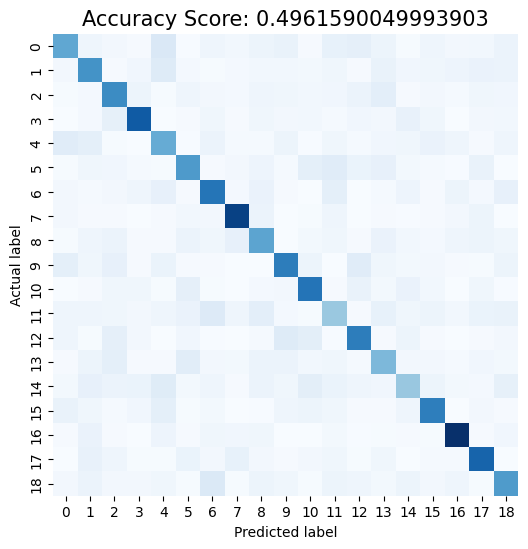




                precision    recall  f1-score   support

        COMEDY       0.48      0.38      0.42       461
 CULTURE & ART       0.43      0.46      0.45       444
     ECONOMICS       0.45      0.50      0.47       425
     EDUCATION       0.65      0.60      0.62       454
 ENTERTAINMENT       0.38      0.42      0.40       398
   ENVIRONMENT       0.48      0.45      0.47       426
        FAMILY       0.49      0.52      0.51       459
          FOOD       0.67      0.72      0.69       428
        LIVING       0.41      0.44      0.43       405
         MEDIA       0.52      0.51      0.52       451
          NEWS       0.53      0.58      0.56       414
        OTHERS       0.32      0.29      0.30       437
      POLITICS       0.52      0.54      0.53       429
SCIENCE & TECH       0.37      0.39      0.38       381
        SOCIAL       0.38      0.29      0.33       449
        SPORTS       0.56      0.55      0.55       416
STYLE & BEAUTY       0.69      0.71      0.7

In [218]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Plot Confusion Matrix
confusion_LR = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,6)); sns.heatmap(confusion_LR,  cmap='Blues', cbar=False)
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15)
plt.show(); print("\n\n")

# 2. Print Report
print(classification_report(y_test, predictions))

### < Result >
* Applying Average-Word2Vec to each document didn't improve the performance

  - because the length of each document is very long in News data, averaging may not work well

* There are some Null data where the document vector is 0.

In [ ]:
!git add .
!git commit -m "averwor2vec"